# Estimación de F (modelos no paramétricos)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Función de distribución empírica

La función de distribución empírica para una muestra $X_1,...,X_n \sim F $ se define  $$\hat{F_n}(x) = \frac{1}{n} \sum_{i=1}^{n}I(X_i\leq x) $$

Es decir, le aplica PMF $ p_{X_i}(x) = p(X_i=x) = \frac{1}{n}$ a cada $X_i$

### Importo datos

Busco $n=100$ datos para estimar la distribución subyacente. Para el ejemplo voy a sacarlos de [este repositorio](https://www.kaggle.com/datasets/tentotheminus9/gravity-spy-gravitational-waves) pero pueden probar con cualquier dataset. En este caso son muestras de tiempos de duración de glitches encontrados en mediciones de LIGO.

(array([57., 12., 12.,  7.,  1.,  2.,  3.,  1.,  1.,  0.,  1.,  1.,  1.,
         0.,  0.,  0.,  1.]),
 array([ 0.01563   ,  0.90441647,  1.79320294,  2.68198941,  3.57077588,
         4.45956235,  5.34834882,  6.23713529,  7.12592176,  8.01470823,
         8.90349471,  9.79228118, 10.68106765, 11.56985412, 12.45864059,
        13.34742706, 14.23621353, 15.125     ]),
 <BarContainer object of 17 artists>)

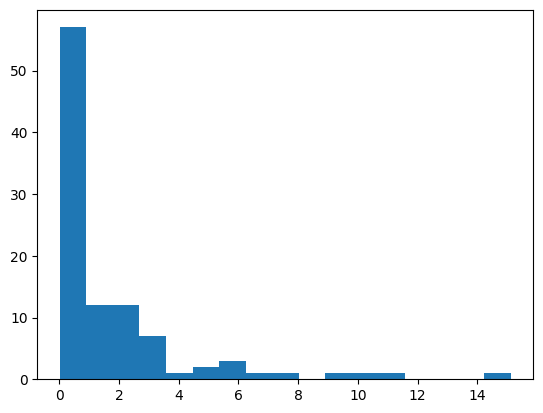

In [35]:
#Importo una muestra cualquiera
import pandas as pd
datos = pd.read_csv('/content/sample_data/trainingset_v1d1_metadata.csv', delimiter=',')
n = 100
sample_data = datos['duration'].sample(n=n)
sample = sample_data.values
plt.hist(sample,bins='auto')

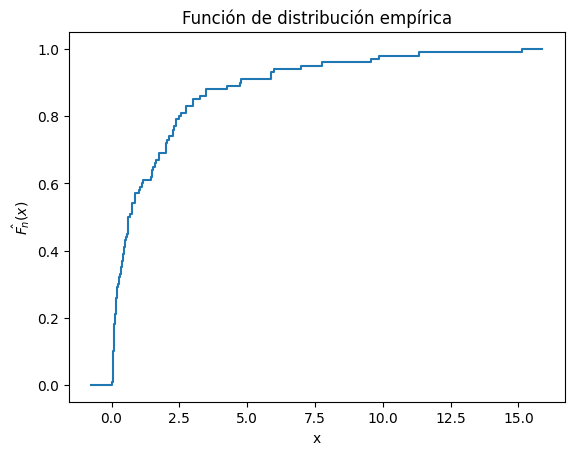

In [36]:
#Defino la distribución empírica F_hat
F_hat = stats.ecdf(sample)

#Para trabajar con la CDF invocamos al atributo cdf y graficamos
ax = plt.subplot()

F_hat.cdf.plot(ax)

ax.set_xlabel('x')
ax.set_ylabel(r'$\hat{F_n}(x)$')
plt.title('Función de distribución empírica')
plt.show()

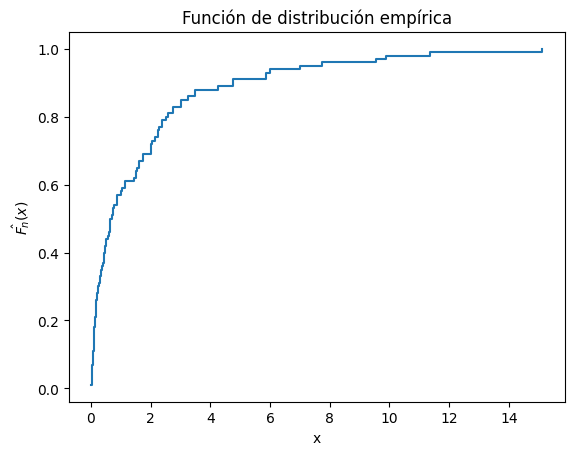

In [37]:
#F_hat.cdf tiene a su vez, dos atributos:
x = F_hat.cdf.quantiles #array con los (X_1,...,X_n) de la muestra ordenados de menor a mayor
F = F_hat.cdf.probabilities #array con la CDF para cada valor correspondiente de x

ax = plt.subplot()

ax.step(x,F,where='post')
#F_hat.cdf.plot(ax,ls=':')

ax.set_xlabel('x')
ax.set_ylabel(r'$\hat{F_n}(x)$')
plt.title('Función de distribución empírica')
plt.show()

In [38]:
#Para evaluar F_hat en un valor arbitrario de x podemos usar el método evaluate(x)
F_hat.cdf.evaluate(2.0)

array(0.72)

### Funcionales estadísticos

Llamamos $T(F)$ a un funcional estadístico de una distribución $F$. Es cualquier cantidad que se pueda calcular como función de $F$ (ej: promedio, varianza, cuantiles, etc.)

Para obtener estimar cualquier $T(F)$ podemos usar el estimador "plug-in", que es simplemente reemplazar $F$ con $\hat{F_n}$.

Por ejemplo, el promedio de una variable aleatoria $X \sim F$ es

$$ \mu = E(X) =  \sum_{x}x p_X(x) \hspace{1cm} \text{(caso discreto)}$$
$$ \mu = E(X) =  \int x f_X(x)dx \hspace{1cm} \text{(caso continuo)} $$

Entonces, el estimador plug-in de $\mu$ será
$$\hat{\mu} = \frac{1}{n}\sum_{i=1}^{n}X_i$$

es decir, el promedio muestral.

Resumidamente, podemos estimar cualquier funcional estadístico por su contraparte muestral.

In [39]:
#algunas características muestrales

#promedio
mean = np.mean(sample)

#varianza
var = np.var(sample)

#desvío estándar (sqrt(var))
std = np.std(sample)

#mediana
median = np.median(sample)

#cuantiles
quantile = np.quantile(sample,q = 0.25)

#asimetría: si es negativa, tiene una cola más larga a la izquierda; positiva, a la derecha
skewness = stats.skew(sample)

#correlación
sample_id = sample_data.index
sample_2 = datos.loc[sample_id, 'amplitude'].values
correlation = stats.pearsonr(sample,sample_2).statistic

print('media =',mean)
print('mediana =',median)
print('std =',std)
print('25-cuartil =',quantile)
print('asimetría = ',skewness)
print('correlación con Y:amplitud =',correlation)

media = 1.7583009005710488
mediana = 0.65625
std = 2.6032530473018363
25-cuartil = 0.1570750027894975
asimetría =  2.6967766837003238
correlación con Y:amplitud = 0.21273785604686163


### Intervalos de confianza

Podemos construír un intervalo de confianza de nivel $1-\alpha$ para $F$ donde los bordes inferiores y superiores $L(x)$ y $U(x)$ son:
$$ L(x) = \max(\hat{F_n}(x)-\epsilon_n,0)$$
$$ U(x) = \min(\hat{F_n}(x)+\epsilon_n,1)$$

con $ \epsilon_n = \sqrt{\frac{1}{2n}\log(\frac{2}{\alpha})} $

Con estos valores, $P(L(x)\leq F(x) \leq U(x) )\geq 1-\alpha$ para cualquier $F$.

Text(0.5, 1.0, 'Función de distribución empírica')

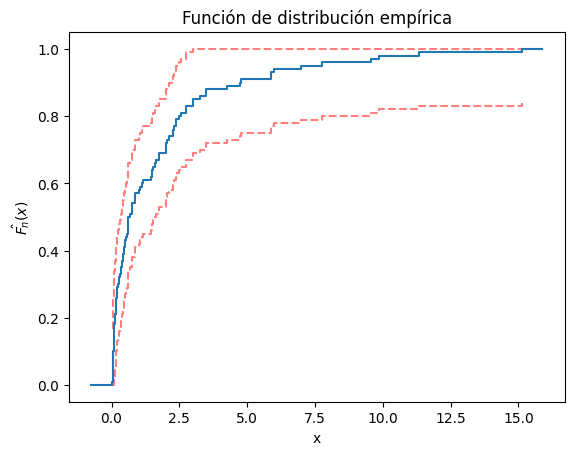

In [40]:
def confidence_interval_dkw(ecdf,alpha=0.05):
  L = []
  U = []
  n = len(ecdf.probabilities)
  epsilon_n = np.sqrt(np.log(2/alpha)/(2*n))
  for i in range(0,n):
    L_i = np.max([ecdf.probabilities[i]-epsilon_n,0])
    U_i = np.min([ecdf.probabilities[i]+epsilon_n,1])
    L.append(L_i)
    U.append(U_i)
  return L,U

low,up = confidence_interval_dkw(F_hat.cdf,alpha=0.05)


ax = plt.subplot()
ax.step(x,low,'r--',alpha=0.5,where='post')
ax.step(x,up,'r--',alpha=0.5,where='post')
F_hat.cdf.plot(ax)
ax.set_xlabel('x')
ax.set_ylabel(r'$\hat{F_n}(x)$')
plt.title('Función de distribución empírica')


### Ejemplo con F~N(0,1)

Empecemos generando una muestra aleatoria $$X_1,...,X_{100} \sim \mathcal{N}(0,1) $$

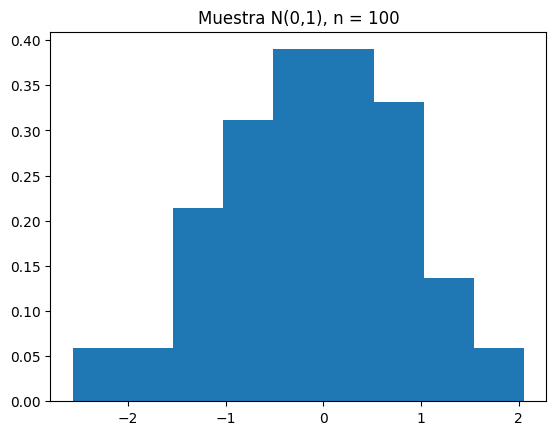

In [41]:
mu = 0
sigma = 1
n = 100

norm_sample = stats.norm.rvs(size=n,loc=mu,scale=sigma)

plt.hist(norm_sample, density=True, bins='auto')
plt.title('Muestra N(0,1), n = {}'.format(n))
plt.show()

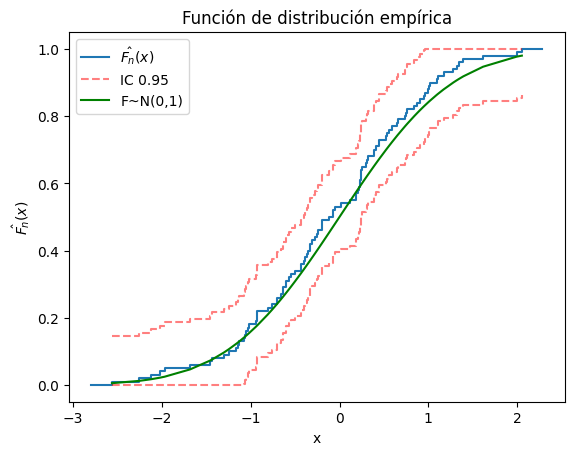

In [42]:
#norm_sample = stats.norm.rvs(size=n,loc=mu,scale=sigma)
F_hat = stats.ecdf(norm_sample)
x = F_hat.cdf.quantiles
F = F_hat.cdf.probabilities

alpha = 0.05
low,up = confidence_interval_dkw(F_hat.cdf,alpha=alpha)


ax = plt.subplot()
F_hat.cdf.plot(ax,label=r'$\hat{F_n}(x)$')
ax.step(x,low,'r--',alpha=0.5,where='post',label='IC {}'.format(1-alpha))
ax.step(x,up,'r--',alpha=0.5,where='post')
ax.plot(x,stats.norm.cdf(x),color='g',label='F~N(0,1)')
ax.set_xlabel('x')
ax.set_ylabel(r'$\hat{F_n}(x)$')
plt.title('Función de distribución empírica')
plt.legend()

Ejercicio: repetir el experimento 1000 veces con un IC de nivel 0.95 y registrar en cuántos casos el intervalo de confianza contiene completamente la función de distribución verdadera.

### Error y desvío estándar de $\hat{\mu}$
Particularmente para el estimador del promedio $\hat{\mu} = \bar{X_n}$ podemos calcular su desvío estándar, ya que es el error estándar del promedio muestral.

$$\text{se}(\hat{\mu}) = \sqrt{\text{var}(\bar{X_n})} = \frac{\sigma}{\sqrt{n}} $$

donde $\sigma$ es el desvío estándar de $X\sim F$. Por lo tanto, para estimar $\text{se}(\hat{\mu})$, reemplazamos $\sigma$ por $\hat{\sigma} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(X_i-\bar{X_n})^{2}}$, el desvío estándar muestral.

También podemos estimar un intervalo de confianza de nivel $1-\alpha$ para $\hat{\mu}$ como
$$\hat{\text{IC}}(\hat{\mu}) = \hat{\mu} \pm z_{\frac{\alpha}{2}}\hat{\text{se}} $$

In [43]:
mean = np.mean(sample)
se_mean = std/np.sqrt(n)

alpha = 0.05
low = mean - stats.norm.ppf(1-alpha/2)*se_mean
up = mean + stats.norm.ppf(1-alpha/2)*se_mean

print('promedio =',mean)
print('error estándar del promedio =',se_mean)
print('IC = ',[low,up])

promedio = 1.7583009005710488
error estándar del promedio = 0.2603253047301836
IC =  [1.2480726790354744, 2.2685291221066235]


### Ejercicio comparación de dos muestras

Tenemos muestras de tamaños de cráneos masculinos encontrados en Egipto que corresponden a dos épocas distintas. Los datos vienen de [este repositorio](https://dasl.datadescription.com/datafile/egyptians/?_sfm_methods=Comparing+Groups&_sfm_cases=4+59943).

Queremos saber si la media de los cráneos es la misma o cambió de una época a la otra. Para eso, hallar un estimador de $\theta = \mu_1-\mu_2$ y proporcionar un error estándar y un interavalo de confianza para este estimador. Decidir si son distintos o no

Text(0.5, 0, 'Tamaño de cráneos')

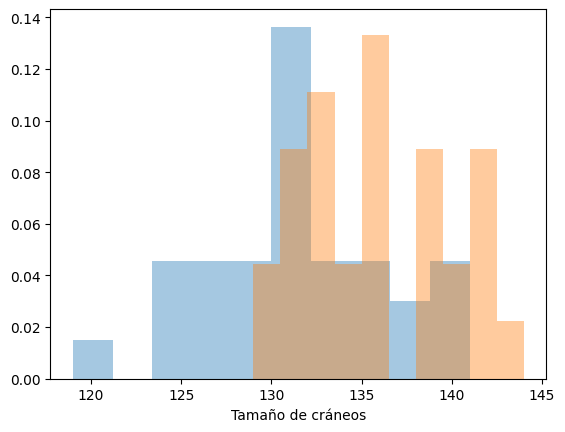

In [44]:
sample2 = pd.read_csv('/content/sample_data/egyptians.txt',delimiter='\t')
grupo1 = sample2['4000 BCE'].values
grupo2 = sample2['200 BCE'].values
plt.hist(grupo1,alpha=0.4,density=True,label = '4000 BCE')
plt.hist(grupo2,alpha=0.4,density=True, label = '200 BCE')
plt.xlabel('Tamaño de cráneos')

Hay que usar $$\hat{\theta} = \hat{\mu_2}-\hat{\mu_1}$$
$$\hat{\text{se}}(\hat{\theta}) = \sqrt{\hat{\text{var}}(\hat{\mu_2}-\hat{\mu_1})} = \sqrt{\hat{\text{se}}(\hat{\mu_2})^{2}+\hat{\text{se}}(\hat{\mu_1})^{2}}$$

In [45]:
mu_1 = np.mean(grupo1)
mu_2 = np.mean(grupo2)
theta = mu_2-mu_1
print('theta = ',theta)

se_1 = np.std(grupo1)/np.sqrt(len(grupo1))
se_2 = np.std(grupo2)/np.sqrt(len(grupo2))
se_theta = np.sqrt(se_1**2+se_2**2)
print('se(theta) = ',se_theta)

alpha = 0.05
low = theta - stats.norm.ppf(1-alpha/2)*se_theta
up = theta + stats.norm.ppf(1-alpha/2)*se_theta
print('IC = ',[low,up])

theta =  4.2666666666666515
se(theta) =  1.171861450538953
IC =  [1.9698604287394375, 6.563472904593866]
